# Vector Database per le Immagini con LanceDB e CLIP

Questo notebook dimostra come utilizzare LanceDB come vector database per dati di immagini, utilizzando CLIP come modello di embedding. Vedremo come:

1. Installare le dipendenze necessarie
2. Caricare e preparare un dataset di immagini
3. Generare embedding per le immagini utilizzando CLIP
4. Caricare gli embedding in LanceDB
5. Eseguire query di ricerca semantica multimodale (testo-immagine)

## Cos'è CLIP?

CLIP (Contrastive Language-Image Pre-training) è un modello sviluppato da OpenAI che crea rappresentazioni vettoriali sia per le immagini che per il testo nello stesso spazio vettoriale. Questo permette di eseguire ricerche multimodali, come cercare immagini utilizzando descrizioni testuali o viceversa.

## 1. Installazione delle dipendenze

Per prima cosa, installiamo le librerie necessarie:

In [1]:
!pip install lancedb torch torchvision ftfy regex tqdm pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [3]:
# Installiamo CLIP da GitHub
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hjh925bc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hjh925bc
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=aedb117b05f57a44aabd20ab1810df756ba096a6566e4c68fdcfae967c0f0445
  Stored in directory: /tmp/pip-ephem-wheel-cache-rgmi85hq/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


## 2. Importazione delle librerie

In [4]:
import os
import torch
import clip
import lancedb
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import requests
from io import BytesIO
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100

## 3. Caricamento del modello CLIP

- https://www.sbert.net/examples/sentence_transformer/applications/image-search/README.html

- https://huggingface.co/sentence-transformers/clip-ViT-B-32

Carichiamo il modello CLIP pre-addestrato:

In [5]:
# Carichiamo il modello CLIP e il preprocessore
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

print(f"Modello CLIP caricato su {device}")

100%|███████████████████████████████████████| 338M/338M [00:13<00:00, 27.2MiB/s]


Modello CLIP caricato su cpu


## 4. Caricamento di un dataset di immagini

Per questo esempio, utilizzeremo il dataset CIFAR-100, che contiene 100 classi di immagini.

In [9]:
# Carichiamo il dataset CIFAR-100
cifar100 = CIFAR100(root='./data', download=True, train=False)

# Prendiamo solo un sottoinsieme delle immagini per questo esempio
num_images = 500
indices = np.random.choice(len(cifar100), num_images, replace=False)

# Estraiamo le immagini e le etichette
images = [cifar100[i][0] for i in indices]
labels = [cifar100.classes[cifar100[i][1]] for i in indices]

print(f"Caricate {len(images)} immagini da {len(set(labels))} classi diverse")

Caricate 500 immagini da 99 classi diverse


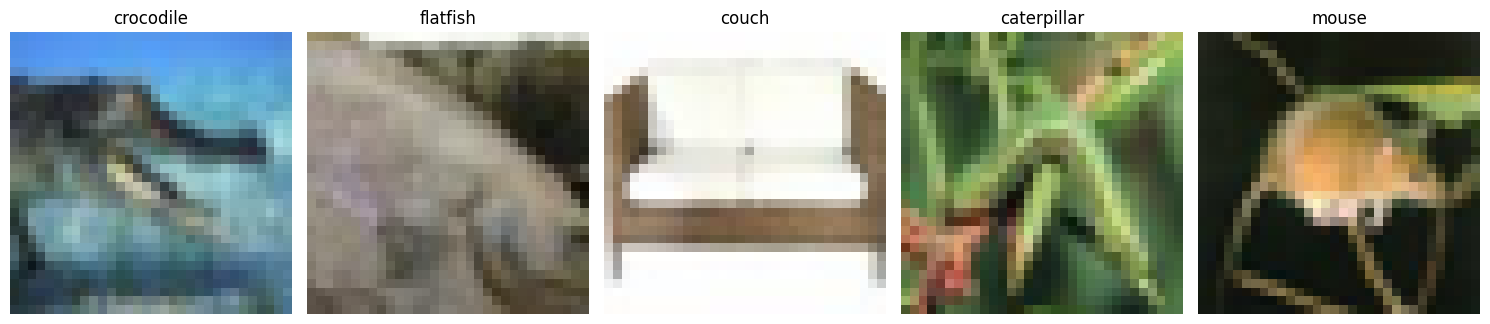

In [10]:
# Visualizziamo alcune immagini di esempio
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Generazione degli embedding con CLIP

Utilizziamo CLIP per generare gli embedding delle immagini:

In [12]:
# Funzione per generare embedding di un'immagine con CLIP
def get_image_embedding(image):
    # Preprocessiamo l'immagine per CLIP
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Generiamo l'embedding
    with torch.no_grad():
        image_features = model.encode_image(image_input)

    # Normalizziamo l'embedding
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # Convertiamo in numpy array
    print(image_features.cpu().numpy()[0])
    return image_features.cpu().numpy()[0]

In [13]:
# Generiamo gli embedding per tutte le immagini
embeddings = []

for image in tqdm(images, desc="Generating embeddings"):
    embedding = get_image_embedding(image)
    embeddings.append(embedding)

print(f"Dimensione di un embedding: {len(embeddings[0])}")

Generating embeddings:   0%|          | 0/500 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  1.96063779e-02  2.42733210e-02 -1.70737077e-02  3.35980058e-02
 -1.32921534e-02 -3.65984463e-03 -1.67406467e-03 -1.94969308e-02
  3.92092094e-02 -3.70482132e-02  1.05031412e-02  7.14450190e-03
  3.95127088e-02 -5.07576298e-03 -6.73612999e-03 -2.92600729e-02
 -1.78274848e-02  5.58931194e-03  7.96616636e-03 -7.68742291e-03
  3.75039056e-02 -3.22771147e-02 -2.05074567e-02  1.58434790e-02
  4.93418286e-03  7.11533427e-02  1.18365148e-02 -9.13526770e-03]
[-2.04502023e-03  3.62197682e-02  5.30210137e-03  1.64669545e-04
  7.87448778e-04 -5.64266592e-02  4.62945476e-02  2.30104458e-02
  1.85461398e-02  2.98671294e-02  4.47084457e-02  4.33686282e-03
 -1.48207201e-02  9.44964850e-05 -3.54165249e-02  5.57815619e-02
  8.94779041e-02  1.94736421e-02 -2.33038906e-02  1.15645945e-03
 -2.87717395e-02  8.11739545e-03 -1.89014822e-02 -5.51260673e-02
  1.75696090e-02 -4.61736554e-03 -1.08874822e-02 -1.79290418e-02
  5.00822067e-03 -1.76853817e-02  3.12

## 6. Creazione del Vector Database con LanceDB

Ora creiamo un database LanceDB e carichiamo i nostri embedding di immagini:

In [14]:
# Convertiamo le immagini PIL in array di byte per salvarle nel database
def image_to_bytes(image):
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return buffer.getvalue()

In [15]:
# Creiamo un dataframe con le immagini, le etichette e gli embedding
data = []
for i in range(len(images)):
    data.append({
        'id': i,
        'label': labels[i],
        'image_bytes': image_to_bytes(images[i]),
        'vector': embeddings[i]
    })

df = pd.DataFrame(data)
print(f"Dataframe shape: {df.shape}")
df[['id', 'label']].head()

Dataframe shape: (500, 4)


,id,label
0,0,crocodile
1,1,flatfish
2,2,couch
3,3,caterpillar
4,4,mouse


In [16]:
# Creiamo un database LanceDB
db_path = "./lancedb_images"
db = lancedb.connect(db_path)

# Creiamo una tabella per i nostri dati
table_name = "cifar_images"

# Se la tabella esiste già, la eliminiamo
if table_name in db.table_names():
    db.drop_table(table_name)

# Creiamo la tabella con i nostri dati
table = db.create_table(table_name, data=df, mode="overwrite")

print(f"Tabella '{table_name}' creata con successo!")

Tabella 'cifar_images' creata con successo!


## 7. Ricerca semantica multimodale (testo-immagine)

Ora possiamo eseguire query semantiche utilizzando descrizioni testuali per trovare immagini simili:

In [17]:
# Funzione per generare embedding di un testo con CLIP
def get_text_embedding(text):
    # Tokenizziamo il testo
    text_input = clip.tokenize([text]).to(device)

    # Generiamo l'embedding
    with torch.no_grad():
        text_features = model.encode_text(text_input)

    # Normalizziamo l'embedding
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Convertiamo in numpy array
    return text_features.cpu().numpy()[0]

In [21]:
# Funzione per visualizzare i risultati della ricerca
def display_results(results, query=None):
    plt.figure(figsize=(15, 10))

    if query:
        plt.suptitle(f"Query: '{query}'", fontsize=16)

    for i, row in enumerate(results.itertuples()):
        if i >= 10:  # Limitiamo a 10 risultati
            break

        # Convertiamo i byte dell'immagine in un oggetto PIL
        image = Image.open(BytesIO(row.image_bytes))

        # Visualizziamo l'immagine
        plt.subplot(2, 5, i+1)
        plt.imshow(image)
        plt.title(f"{row.label}\n")
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [19]:
def semantic_search(query_text, top_k=10):
    """
    Esegue una ricerca semantica nel vector database utilizzando una query testuale.

    Args:
        query_text (str): Il testo della query
        top_k (int): Numero di risultati da restituire

    Returns:
        DataFrame: Dataframe con i risultati più rilevanti
    """
    # Generiamo l'embedding per la query testuale
    query_embedding = get_text_embedding(query_text)

    # Eseguiamo la ricerca vettoriale
    results = table.search(query_embedding).limit(top_k).to_pandas()

    return results

Query: 'un animale della savana'
Trovate 10 immagini simili


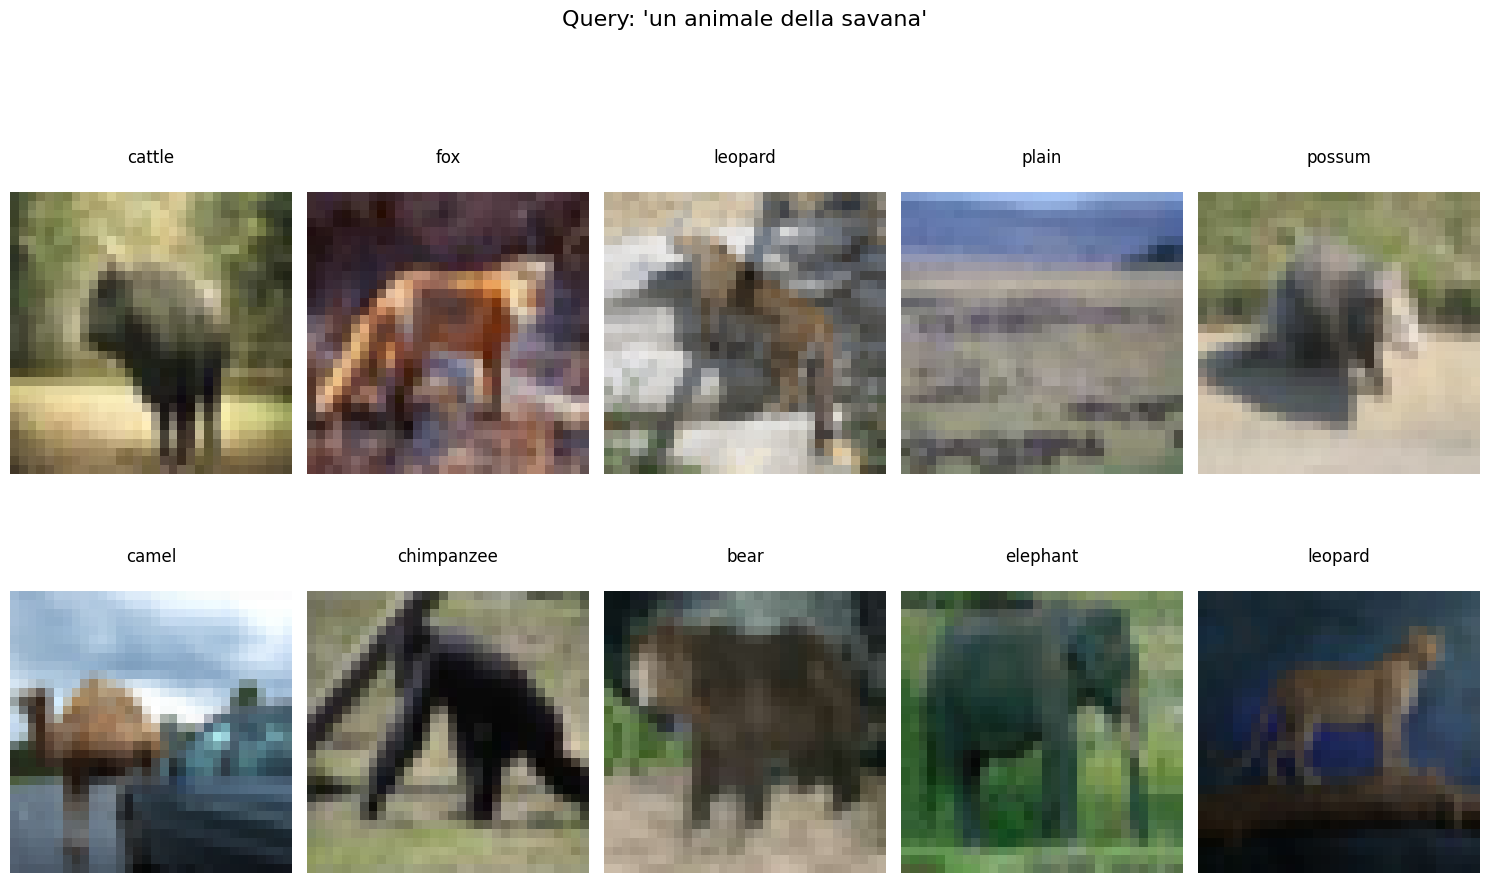

In [24]:
# Esempio di query semantica
query = "un animale della savana"
results = semantic_search(query)

print(f"Query: '{query}'")
print(f"Trovate {len(results)} immagini simili")

# Visualizziamo i risultati
display_results(results, query)

Query: 'un veicolo di trasporto'
Trovate 10 immagini simili


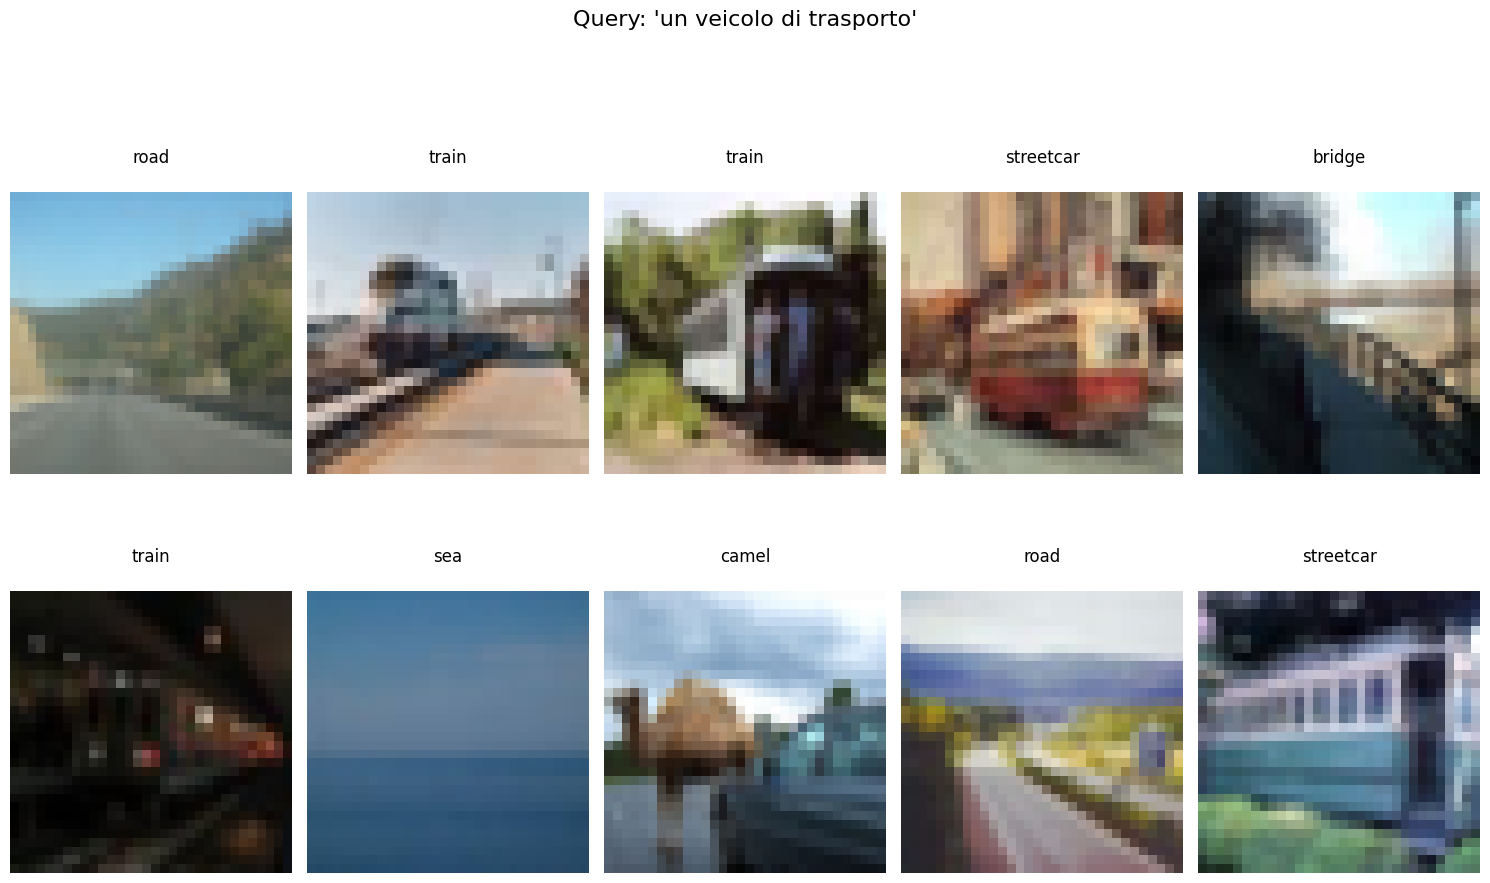

In [23]:
# Proviamo un'altra query
query = "un veicolo di trasporto"
results = semantic_search(query)

print(f"Query: '{query}'")
print(f"Trovate {len(results)} immagini simili")

# Visualizziamo i risultati
display_results(results, query)

## 8. Ricerca per similarità di immagine

Possiamo anche cercare immagini simili a un'immagine di riferimento:

In [25]:
def image_search(query_image, top_k=10):
    """
    Esegue una ricerca semantica nel vector database utilizzando un'immagine come query.

    Args:
        query_image (PIL.Image): L'immagine di query
        top_k (int): Numero di risultati da restituire

    Returns:
        DataFrame: Dataframe con i risultati più rilevanti
    """
    # Generiamo l'embedding per l'immagine di query
    query_embedding = get_image_embedding(query_image)

    # Eseguiamo la ricerca vettoriale
    results = table.search(query_embedding).limit(top_k).to_pandas()

    return results

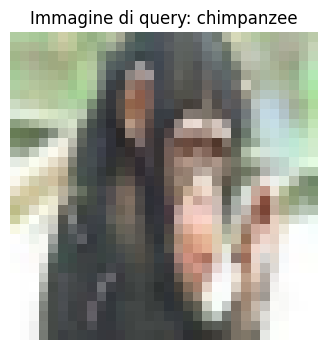

[ 2.08698809e-02  7.95427337e-03 -2.20868774e-02 -8.81158467e-03
  1.31082376e-02  1.08195841e-02  2.22255215e-02  6.02111369e-02
  1.99159682e-02  1.77875608e-02  3.72247323e-02  4.19659317e-02
  2.97289044e-02 -1.82894338e-02 -2.89023723e-02  8.06912966e-03
  1.14198793e-02  1.36377541e-02  3.98138314e-02  2.39358675e-02
  1.14645800e-02  1.34696038e-02  6.02335250e-03 -2.43690778e-02
 -2.82010995e-02  4.90702363e-03  6.17075386e-03  1.44521678e-02
  4.78118239e-03  2.11097561e-02  8.02592933e-03 -4.44269031e-02
  6.18020399e-03 -1.08850403e-02 -2.15097796e-02 -4.40682434e-02
 -1.98776973e-03 -3.49374348e-03 -4.39516492e-02  1.93914324e-02
  4.56236675e-03  7.29122153e-03 -1.49808414e-02 -1.84815470e-02
 -2.38485839e-02  1.45718858e-01 -4.15800288e-02  3.92201766e-02
  3.12209260e-02 -2.50145793e-02 -2.36668915e-04  4.02321368e-02
  1.82380956e-02  1.87761616e-02  2.45920997e-02  3.49743851e-03
  4.19621356e-02  4.89899665e-02 -1.48442555e-02  1.52489962e-02
  5.58541566e-02 -1.67177

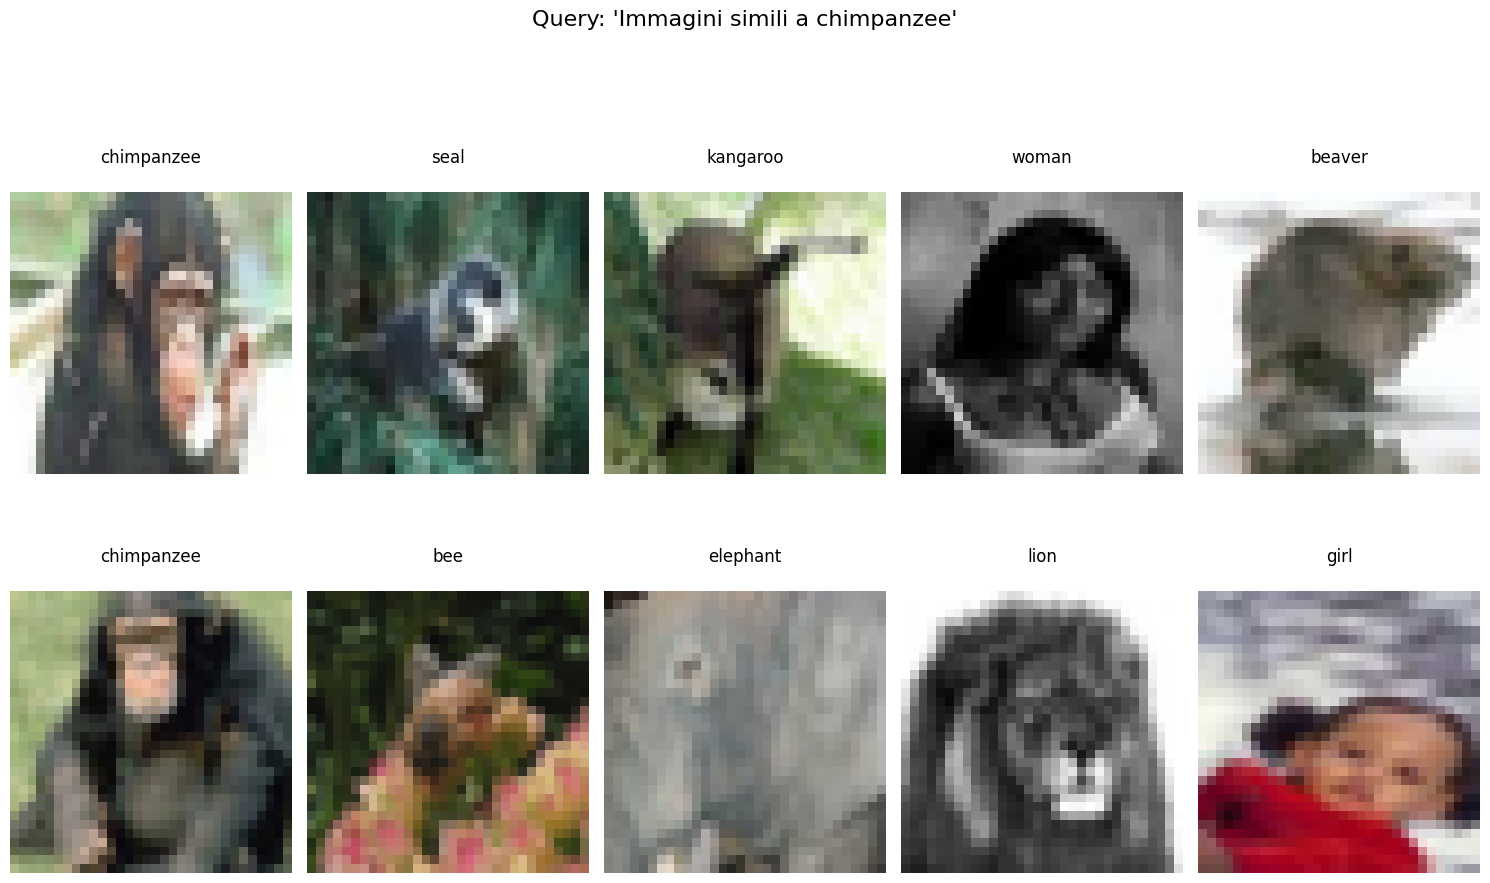

In [26]:
# Scegliamo un'immagine casuale come query
query_idx = np.random.randint(0, len(images))
query_image = images[query_idx]
query_label = labels[query_idx]

# Visualizziamo l'immagine di query
plt.figure(figsize=(4, 4))
plt.imshow(query_image)
plt.title(f"Immagine di query: {query_label}")
plt.axis('off')
plt.show()

# Eseguiamo la ricerca
results = image_search(query_image)

print(f"Cercando immagini simili a: {query_label}")
print(f"Trovate {len(results)} immagini simili")

# Visualizziamo i risultati
display_results(results, f"Immagini simili a {query_label}")

## 9. Filtraggio dei risultati

Possiamo anche filtrare i risultati in base alle etichette:

In [27]:
def filtered_search(query_text, label_filter=None, top_k=10):
    """
    Esegue una ricerca semantica con filtro sull'etichetta.

    Args:
        query_text (str): Il testo della query
        label_filter (str): Filtro sull'etichetta (opzionale)
        top_k (int): Numero di risultati da restituire

    Returns:
        DataFrame: Dataframe con i risultati più rilevanti
    """
    # Generiamo l'embedding per la query testuale
    query_embedding = get_text_embedding(query_text)

    # Prepariamo la query
    search_query = table.search(query_embedding)

    # Applichiamo il filtro se specificato
    if label_filter:
        search_query = search_query.where(f"label = '{label_filter}'")

    # Eseguiamo la ricerca
    results = search_query.limit(top_k).to_pandas()

    return results

Query: 'un oggetto colorato' (filtro etichetta: 'apple')
Trovate 6 immagini simili


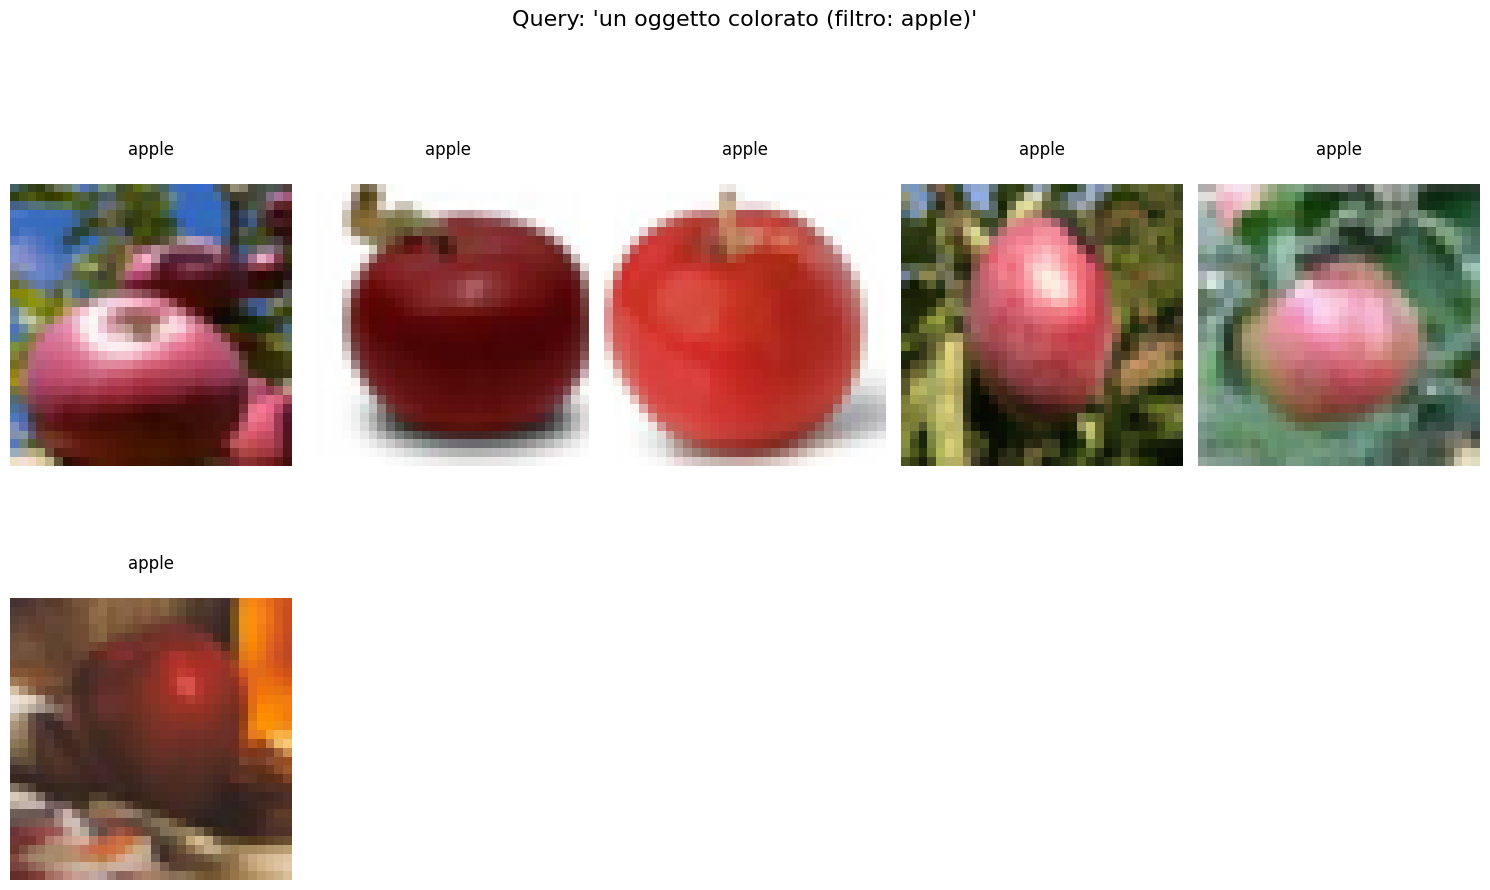

In [28]:
# Esempio di ricerca con filtro
query = "un oggetto colorato"
label_filter = "apple"  # Filtriamo solo le mele

results = filtered_search(query, label_filter)

print(f"Query: '{query}' (filtro etichetta: '{label_filter}')")
print(f"Trovate {len(results)} immagini simili")

# Visualizziamo i risultati
if len(results) > 0:
    display_results(results, f"{query} (filtro: {label_filter})")
else:
    print("Nessun risultato trovato con questo filtro. Prova con un'altra etichetta.")

## 10. Conclusioni

In questo notebook abbiamo visto come:

1. Caricare e preparare un dataset di immagini
2. Generare embedding per le immagini utilizzando CLIP
3. Creare un vector database con LanceDB
4. Eseguire query semantiche multimodali (testo-immagine)
5. Cercare immagini simili a un'immagine di riferimento
6. Filtrare i risultati in base ai metadati

I vector database come LanceDB combinati con modelli multimodali come CLIP offrono potenti capacità di ricerca semantica per le immagini, consentendo di trovare immagini simili utilizzando descrizioni testuali o altre immagini come riferimento.

## Esercizi aggiuntivi

1. Prova a utilizzare un modello CLIP diverso (ad esempio, "ViT-L/14")
2. Sperimenta con un dataset di immagini più grande o diverso
3. Implementa una funzione per combinare query testuali e di immagine
4. Crea un'interfaccia utente semplice per la ricerca di immagini